In [ ]:
!pip install simpletransformers
!python3 -m spacy download en_core_web_md

     |████████████████████████████████| 225kB 7.6MB/s 
     |████████████████████████████████| 245kB 14.7MB/s 
     |████████████████████████████████| 122kB 15.9MB/s 
     |████████████████████████████████| 2.5MB 14.9MB/s 
     |████████████████████████████████| 7.8MB 53.0MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 3.3MB 42.8MB/s 
     |████████████████████████████████| 1.2MB 44.0MB/s 
     |████████████████████████████████| 1.8MB 49.2MB/s 
     |████████████████████████████████| 245kB 49.1MB/s 
     |████████████████████████████████| 122kB 54.8MB/s 
     |████████████████████████████████| 901kB 43.3MB/s 
     |████████████████████████████████| 112kB 59.7MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 4.2MB 37.1MB/s 
     |████████████████████████████████| 174kB 55.7MB/s 
     |████████████████████████████████| 133kB 60.0MB/

In [ ]:
import re

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np


import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from simpletransformers.ner import NERModel, NERArgs

OSError: ignored

#Chargement Corpus

In [ ]:
def from_xml_to_df(fichierxml,limitedebut=None,limitefin=None,skip=[], documentlevel=False, selecteur="mention,meronyme"):
    'Extrait les phrases et retourne un dataframe contenant les token au format BIO'
    if limitedebut and limitefin:
      assert limitedebut <= limitefin
    dico = {"mention":"Mention_La_Defense","meronyme":"Mention_Meronyme_La_Defense"}
    soup = BeautifulSoup(open(fichierxml,encoding="utf8"), 'lxml')
    data = []
    i=0
    for texte in soup.select("article > texte,titre"):
        ident = int(texte.parent.get('id'))
        print(ident)
        if (limitedebut and ident < limitedebut) or (ident in skip): continue
        if limitefin and ident > limitefin: break
        
        ls_mentions = []
        for mention in texte.select(selecteur):
            ls_mentions.append((mention.text, dico[mention.name]))
            mention.string = "ENTITE_MENTION_La_Defense"
        
        doc = nlp(texte.text, disable=[ 'tagger', 'ner'])
        for sent in doc.sents:
            for token in sent:
                if token.is_space:continue
                if token.text == "ENTITE_MENTION_La_Defense":
                    tup = ls_mentions.pop(0)
                    doc2 = nlp(tup[0], disable=['parser', 'tagger', 'ner'])
                    l = 0
                    for token2 in doc2:
                        if l:
                          BIO = "I-"
                        else:
                          BIO = "B-"
                            
                        data.append([i, token2.text, BIO+tup[1]])
                        l+=1
                else:
                    data.append([i, token.text, "O"])
            if not documentlevel:
                i+=1
        if documentlevel:
            i+=1
            
    df = pd.DataFrame(data,columns=["sentence_id","words","labels"])
    
    return df

In [ ]:
def train_test_split_tokens(df, taille_train):
  '''coupe la dataframe en deux dataframes selon une portion indiquée'''
  phrases = df.sentence_id.unique()
  phrases_train, phrases_test = train_test_split(phrases,train_size=taille_train)
  df_train = df[df.sentence_id.isin(phrases_train)]
  df_test = df[df.sentence_id.isin(phrases_test)]
  return df_train,df_test

In [ ]:
fichierxml = chemin + "/Corpus/Presse/grandfinalEN_indexé.xml"
df_corpus =from_xml_to_df(fichierxml,limitedebut=354,limitefin=404,documentlevel=False)
df_corpus.to_csv(chemin+"/tokens_entites_mentions_EN.csv",sep='\t',index=False)

In [ ]:
df_corpus = pd.read_csv(chemin+"/tokens_entites_mentions_EN.csv",sep="\t")

#Entraînement

On prépare le modèle. On lui indique les etiquettes possibles.
20 époques.
Besoin d'utiliser un bon GPU (comme ceux de Google) sinon c'est beaucoup trop long

In [ ]:
custom_labels = ["O","B-Mention_La_Defense","B-Mention_Meronyme_La_Defense","I-Mention_La_Defense","I-Mention_Meronyme_La_Defense"]

model_args = NERArgs()
model_args.labels_list = custom_labels
model_args.num_train_epochs = 20
model_args.overwrite_output_dir = True
#model_args.evaluate_during_training = True


In [ ]:
def validation_croisee(df,model_args,plis=2):
  
  df = df[df.sentence_id.isin(df.sentence_id[df.labels != "O"])]
  X1 = df.sentence_id.to_numpy()
  X2 = df.words.to_numpy()
  y = df.labels.to_numpy()
  X = []
  y_true,y_pred = [], []
  phrases = df.sentence_id.unique()
  #phrases_train, phrases_test = train_test_split(phrases,train_size=taille_train)
  kf = KFold(n_splits=plis, random_state=None)
  scores = []
  for train_index, test_index in kf.split(phrases):
    phrases_train = phrases[train_index]
    phrases_test = phrases[test_index]
    df_train = df[df.sentence_id.isin(phrases_train)]
    print("chargement et entraînement")
    
    model = NERModel("roberta","roberta-base",args=model_args,labels=custom_labels)
    #df_train = pd.DataFrame(np.stack((X1_train,X2,train,y_train), columns=["sentence_id","words","labels"]))
    #df_test = pd.DataFrame(np.stack((X1_test,X2,test,y_test), columns=["sentence_id","words","labels"]))
    df_test = df[df.sentence_id.isin(phrases_test)]
    print(df_test)
    y_test = df_test.labels.tolist()

    model.train_model(df_train,
                  output_dir=chemin+"/Modeles/Modele_Camembert_1")
    '''
    result, model_outputs, preds_list = model.eval_model(df_test)
    scores.append(result)
    '''
    to_predict= []
    for phrase in phrases_test:
      words = df_test[df_test.sentence_id == phrase].words.tolist()
      to_predict.append(words)
    #print("WA", len())
    words_to_pred = [w for u in to_predict for w in u]
    preds_list,ouputs = model.predict(to_predict, split_on_space=False)
    print("to_predict",to_predict)
    print("preds_list",preds_list)
    X.extend(words_to_pred)
    y_true.extend(y_test)
    #preds = preds_list
    preds =[(dic[word],word) for phrase in preds_list for dic in phrase for word,label in dic.items()]
    print(preds)
    assert len(words_to_pred)==len(y_test)
    for i in range(len(y_test) - 1):
      if len(y_test)>len(preds):
         if words_to_pred[i] != preds[i][1] and words_to_pred[i+1] == preds[i][1]:
          print("DIFFERENT",i, words_to_pred[i], preds[i])
          print(words_to_pred[i+1],preds[i][1] )
          preds.insert(i,("O","."))
          
          #break
      else:
        break
    preds = [pred[0] for pred in preds]
    print(len(df_test.index), len(df_test.words),len(y_test),len(preds))

    y_pred.extend(preds)
    
  return model,X, y_true,y_pred


    
    

    

In [ ]:
last_model,X, y_true, y_pred = validation_croisee(df_corpus,model_args,plis=5)

chargement et entraînement


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

      sentence_id         words                labels
8               1      launches                     O
9               1  construction                     O
10              1          with                     O
11              1         VINCI                     O
12              1            of                     O
...           ...           ...                   ...
1770          101            La  B-Mention_La_Defense
1771          101       Defense  I-Mention_La_Defense
1772          101             ,                     O
1773          101        France                     O
1774          101             )                     O

[556 rows x 3 columns]


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:739: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

to_predict [['launches', 'construction', 'with', 'VINCI', 'of', 'Paris', 'La', 'Defense', ',', 'in', 'partnership', 'with', 'Paris', 'La', 'Defense'], ['11062020', '-', 'Paris', 'La', 'Defense', '-', 'Groupama', 'Group', 'and', 'Total', 'signed', 'an', 'off', '-', 'plan', 'lease', 'on', '14', 'March', '2020', 'covering', 'the', 'construction', 'of', 'The', 'Link', ',', 'Total', "'s", 'new', 'head', 'office', 'in', 'Paris', 'La', 'Defense', '.'], ['At', 'the', 'end', 'of', 'the', 'works', 'and', 'fitting', 'out', ',', 'scheduled', 'to', 'take', 'five', 'years', ',', 'Total', 'will', 'take', 'delivery', 'of', 'the', 'Paris', 'La', 'Defense', 'district', 'and', 'lease', 'our', 'business', 'district', 'for', 'a', '12-year', 'renewable', 'period', '.'], ["'", 'Paris', 'La', 'Defense', 'is', 'specifically', 'designed', 'to', 'meet', 'Total', "'s", 'needs', '.'], ["'", 'With', 'Paris', 'La', 'Defense', ',', 'we', 'will', 'bring', 'together', 'our', 'teams', ',', 'currently', 'spread', 'across

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

       sentence_id     words                         labels
1780           104    Thales                              O
1781           104         e                              O
1782           104         -                              O
1783           104  Security                              O
1784           104         (                              O
...            ...       ...                            ...
13808          904       the  B-Mention_Meronyme_La_Defense
13809          904        La  I-Mention_Meronyme_La_Defense
13810          904   Defense  I-Mention_Meronyme_La_Defense
13811          904     Arena  I-Mention_Meronyme_La_Defense
13812          904         .                              O

[734 rows x 3 columns]


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:739: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

to_predict [['Thales', 'e', '-', 'Security', '(', 'La', 'Defense', ',', 'France', ')', 'Revenue', 'in', 'Cloud', 'Encryption', 'Service', 'Business', '(', '2015', '-', '2020', ')', ')'], ['Thales', 'e', '-', 'Security', '(', 'La', 'Defense', ',', 'France', ')'], ['And', 'so', 'an', 'era', 'ends', 'for', 'Saracens', ',', 'a', 'time', 'of', 'notable', 'glory', 'but', 'also', 'of', 'controversy', ',', 'a', 'stain', 'forever', 'etched', 'on', 'their', 'reputations', 'despite', 'the', 'typically', 'lung', '-', 'busting', ',', 'gritty', ',', 'defiant', 'play', 'on', 'show', 'at', 'La', 'Defense', ',', 'qualities', 'that', 'have', 'brought', 'them', 'countless', 'trophies', 'but', 'were', 'not', 'enough', 'to', 'deny', 'Racing', '92', 'a', 'place', 'in', 'their', 'third', 'European', 'final', 'in', 'five', 'seasons', '.'], ['The', 'powerhouse', 'centre', 'was', 'off', 'and', 'away', ',', 'stepping', 'and', 'fending', ',', 'finding', 'Russell', 'on', 'the', 'outside', 'when', 'finally', 'felle

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

       sentence_id     words labels
15044          965        By      O
15045          965  contrast      O
15046          965         ,      O
15047          965   vacancy      O
15048          965     rates      O
...            ...       ...    ...
34113         1970        to      O
34114         1970       the      O
34115         1970    French      O
34116         1970   capital      O
34117         1970         .      O

[696 rows x 3 columns]


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:739: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

to_predict [['By', 'contrast', ',', 'vacancy', 'rates', 'in', 'La', 'Défense', 'in', 'Paris', 'have', 'fallen', 'more', 'than', '20', 'per', 'cent', '.'], ['But', 'the', 'stakes', 'have', 'risen', 'again', ',', 'today', ',', 'when', 'they', 'face', 'a', 'starstudded', 'Racing', '92', 'side', 'at', 'the', 'La', 'Defense', 'Arena', 'in', 'Paris', 'for', 'a', 'place', 'in', 'next', 'month', "'s", 'final', '.'], ['Racing', "'s", 'Paris', 'La', 'Defense', 'Arena', ',', 'which', 'Lewington', 'describes', 'as', '"', 'incredible', ',', 'like', 'playing', 'a', 'rugby', 'match', 'in', 'the', 'O2', 'Arena', '"', ',', 'is', 'no', 'mystery', 'either', '.'], ['Juan', 'Imhoff', "'s", 'try', ',', 'the', 'only', 'one', 'of', 'the', 'match', ',', 'meant', 'that', 'all', 'of', 'Saracens', "'", 'dogged', 'work', 'in', 'the', 'second', 'half', 'to', 'take', 'charge', 'of', 'affairs', 'in', 'La', 'Defense', 'Arena', 'were', 'for', 'nothing', '.'], ['Arnold', 'links', 'up', 'with', 'Tom', 'Daly', 'in', 'the'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

       sentence_id     words labels
34118         1971       The      O
34119         1971    advert      O
34120         1971         ,      O
34121         1971     which      O
34122         1971  features      O
...            ...       ...    ...
50202         2645      from      O
50203         2645      1984      O
50204         2645        to      O
50205         2645      1992      O
50206         2645         .      O

[837 rows x 3 columns]


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:739: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

to_predict [['The', 'advert', ',', 'which', 'features', 'a', 'large', 'frog', 'wearing', 'a', 'French', 'tricolore', 'tie', 'sitting', 'in', 'front', 'of', 'La', 'Défense', "'s", 'skyscrapers', ',', 'is', 'the', 'latest', 'in', 'measures', 'aimed', 'at', 'capitalising', 'on', 'the', 'uncertainty', 'created', 'by', 'the', 'Brexit', 'vote', 'and', 'attracting', 'big', 'financial', 'groups', 'to', 'Paris', '.'], ['but', 'it', "'s", 'a', 'fantastic', 'opportunity', 'for', 'Paris', 'and', 'its', 'business', 'district', ',', '"', 'said', 'Marie', '-', 'Célie', 'Guillaume', ',', 'chief', 'executive', 'of', 'Defacto', 'La', 'Défense', ',', 'the', 'body', 'responsible', 'for', 'managing', 'the', 'finance', 'hub', 'in', 'western', 'Paris', '.'], ['La', 'Défense', 'is', 'Europe', "'s", 'largest', 'business', 'district', ',', 'home', 'to', '400', 'companies', 'and', '160,000', 'employees', '.'], ['It', 'includes', 'the', 'likes', 'of', 'HSBC', ',', 'Société', 'Générale', ',', 'EY', ',', 'KPMG', 'a

#Tests

# Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score

In [ ]:
y_pred = np.array([item for sublist in preds_list for item in sublist], dtype='str')
y_true = df_test.labels.to_numpy(dtype='str')
df_test["labels_pred"] = y_pred

## Evaluation sévère

In [ ]:
rappel = recall_score(y_true=y_true, y_pred=y_pred, labels=custom_labels, average=None)
precision = precision_score(y_true=y_true, y_pred=y_pred, labels=custom_labels, average=None)

In [ ]:
df_resultats = pd.DataFrame({"Rappel":rappel,"Précision":precision}, index=custom_labels)

In [ ]:
df_resultats

Rappel  Précision
O                              0.968893   0.956201
B-Mention_La_Defense           0.835821   0.700000
B-Mention_Meronyme_La_Defense  0.395833   0.612903
I-Mention_La_Defense           0.800000   0.729412
I-Mention_Meronyme_La_Defense  0.549296   0.787879

## Evaluation relâchée

In [ ]:
custom_labels_relax = ["Mention_La_Defense","Mention_Meronyme_La_Defense","O"]


In [ ]:
y_true_relax = np.char.lstrip(np.char.lstrip(y_true,"B-"), "I-")
y_pred_relax = np.char.lstrip(np.char.lstrip(y_pred,"B-"), "I-")

In [ ]:
y_true_relax

array(['O', 'O', 'O', ..., 'O', 'O', 'O'], dtype='<U29')

In [ ]:
res = classification_report(y_true_relax,y_pred_relax)

In [ ]:
print(res)

                             precision    recall  f1-score   support

         Mention_La_Defense       0.76      0.86      0.81       222
Mention_Meronyme_La_Defense       0.78      0.53      0.63       190
                          O       0.96      0.97      0.96      2411

                   accuracy                           0.93      2823
                  macro avg       0.83      0.79      0.80      2823
               weighted avg       0.93      0.93      0.93      2823



In [ ]:
rappel_relax = recall_score(y_true=y_true_relax, y_pred=y_pred_relax, labels=custom_labels_relax, average=None)
precision_relax = precision_score(y_true=y_true_relax, y_pred=y_pred_relax, labels=custom_labels_relax, average=None)

In [ ]:
df_resultats_relax = pd.DataFrame({"Rappel":rappel_relax,"Précision":precision_relax}, index=custom_labels_relax)

In [ ]:
df_resultats_relax

Rappel  Précision
Mention_La_Defense           0.855856   0.760000
Mention_Meronyme_La_Defense  0.531579   0.776923
O                            0.968893   0.956201

In [ ]:
matrice_brute = confusion_matrix(y_true_relax, y_pred_relax, labels=custom_labels_relax)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
labels =  ["La_Defense","Meronyme","O"]

In [ ]:
matrice_confusion = pd.DataFrame(matrice_brute,
                                 index=labels,
                                 columns=labels)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

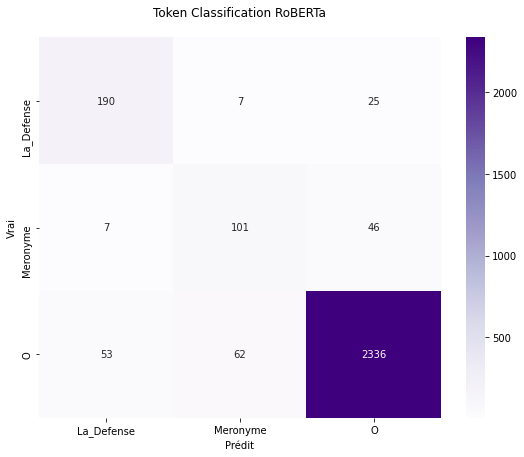

In [ ]:
plt.figure(figsize=(9,7))
sns.heatmap(matrice_confusion, annot=True, cmap='Purples', fmt='g')
plt.title(f'Token Classification RoBERTa\n')
plt.ylabel('Vrai')
plt.xlabel('Prédit')
plt.show()

# Etiquettage Automatique

On va maintenant appliquer le modèle sur l'ensemble du corpus pour l'étiquetter automatiquement

In [ ]:
import glob, os

In [ ]:
def reprettify(pretty):
  ''' Rend le xml final un peu plus joli'''
    reg = re.compile("\n {5,}(</?\w+>)\n {5,}")
    return reg.sub("\\1",pretty)

In [ ]:
def Etiquettage_RoBERTa(fichier_entree_xml, fichier_sortie_xml, model):
  '''prend un fichier xml en entrée et un modèle entraîné puis produit un nouveau fichier xml avec les balises ajoutées'''
  dico = {"mention":"Mention_La_Defense","meronyme":"Mention_Meronyme_La_Defense"}
  dico = {v:k for k,v in dico.items()}
  soup = BeautifulSoup(open(fichierxml,encoding="utf8"), 'lxml')
  
  if type(model)== str:
    fichier_modele = glob.glob(model+"/*")[-1] + "/model_args.json"
    model = NERModel("camembert",fichier_modele)
  for texte in soup.select("article > texte,titre"):
    parent = texte.parent
    tag = texte.name
    ident = int(parent.get("id"))
    print(ident)
    list_sent_token = [[token.text for token in sent] for sent in nlp(texte.text).sents]
    preds_list = model.predict(list_sent_token, split_on_space=False)
    texte_balisé = balise_texte(preds_list, dico)
    element_modifie = BeautifulSoup(f"<{tag}>{texte_balisé}</{tag}>",'html.parser')
    texte.replaceWith(element_modifie)
    #if ident > 2:
      #break
    print("\n\n")
  pretty = soup.prettify()
  pretty = reprettify(pretty)
  open(fichier_sortie_xml,"w",encoding="utf8").write(pretty)
    

  


In [ ]:
def balise_texte(predictions, dico):
  '''Balise un article avec les résultats de la détection automatique'''
  texte_balisé = ""
  for preds, brut in zip(*predictions):
    print()
    for i in range(len(preds)):
      pred = preds[i]
      k, v  = [kv for kv in pred.items()][0]
      #print(k,"\t:\t",v)
      if v == "O":
        texte_balisé += k
      elif v.startswith("B-"):
        texte_balisé += "<"+ dico.get(v.strip('B-'))+">"+k
        try:
          k2, v2  = [kv2 for kv2 in preds[i+1].items()][0]
          if not v2.startswith("I-"):
            texte_balisé+= "</"+ dico.get(v.strip('B-'))+">"
        except IndexError:
          texte_balisé+= "</"+ dico.get(v.strip('B-'))+">"
      else:
        try:
          k2, v2  = [kv2 for kv2 in preds[i+1].items()][0]
          if v2.startswith("I-"):
            texte_balisé += k
          else:
            texte_balisé += k+"</"+ dico.get(v.strip('I-'))+">"
        except IndexError:
          texte_balisé += k+"</"+ dico.get(v.strip('I-'))+">"
      texte_balisé+=" "
    texte_balisé +="\n"
    #print(texte_balisé)
  return texte_balisé



In [ ]:
Etiquettage_RoBERTa(chemin+"/Corpus/Presse/grandfinal.xml",chemin+"/Corpus/Presse/grandfinal_annoté_camembert.xml", model)

1


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























2


  0%|          | 0/103 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/13 [00:00<?, ?it/s]











































































































3


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























4


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















5


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































6


  0%|          | 0/37 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]









































7


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































8


  0%|          | 0/42 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]














































9


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























10


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























11


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























12


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































13


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























14


  0%|          | 0/51 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]























































15


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























16


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























17


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












18


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























19


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















20


  0%|          | 0/68 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/9 [00:00<?, ?it/s]








































































21


  0%|          | 0/37 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]









































22


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































23


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























24


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























25


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































26


  0%|          | 0/33 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]





































27


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







28


  0%|          | 0/48 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]




















































29


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























30


  0%|          | 0/48 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]




















































31


  0%|          | 0/37 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]









































32


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































33


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








34


  0%|          | 0/38 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]










































35


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























36


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























37


  0%|          | 0/31 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]



































38


  0%|          | 0/83 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]























































































39


  0%|          | 0/25 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]





























40


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































41


  0%|          | 0/64 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]




































































42


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































43


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















44


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























45


  0%|          | 0/115 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/15 [00:00<?, ?it/s]























































































































46


  0%|          | 0/25 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]





























47


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









48


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















49


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










50


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












51


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























52


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















53


  0%|          | 0/11 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]















54


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











55


  0%|          | 0/15 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]



















56


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









57


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























58


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









59


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































60


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










61


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










62


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































63


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















64


  0%|          | 0/41 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]













































65


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































66


  0%|          | 0/37 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]









































67


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























68


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























69


  0%|          | 0/53 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]

























































70


  0%|          | 0/52 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]
























































71


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































72


  0%|          | 0/92 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/12 [00:00<?, ?it/s]
































































































73


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































74


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































75


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































76


  0%|          | 0/54 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]


























































77


  0%|          | 0/36 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]








































78


  0%|          | 0/46 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]


















































79


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























80


  0%|          | 0/152 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/19 [00:00<?, ?it/s]




























































































































































81


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





82


  0%|          | 0/85 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]

























































































83


  0%|          | 0/61 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]

































































84


  0%|          | 0/14 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]


















85


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















86


  0%|          | 0/102 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/13 [00:00<?, ?it/s]










































































































87


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























88


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























89


  0%|          | 0/42 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]














































90


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































91


  0%|          | 0/97 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/13 [00:00<?, ?it/s]





































































































92


  0%|          | 0/47 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]



















































93


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































94


  0%|          | 0/48 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]




















































95


  0%|          | 0/42 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]














































96


  0%|          | 0/73 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/10 [00:00<?, ?it/s]













































































97


  0%|          | 0/15 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]



















98


  0%|          | 0/76 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/10 [00:00<?, ?it/s]
















































































99


  0%|          | 0/87 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]



























































































100


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























101


  0%|          | 0/40 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]












































102


  0%|          | 0/33 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]





































103


  0%|          | 0/86 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]


























































































104


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































105


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































106


  0%|          | 0/81 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]





















































































107


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































108


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















109


  0%|          | 0/56 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]




























































110


  0%|          | 0/43 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]















































111


  0%|          | 0/81 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]





















































































112


  0%|          | 0/47 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]



















































113


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































114


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































115


  0%|          | 0/31 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]



































116


  0%|          | 0/43 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]















































117


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












118


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























119


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























120


  0%|          | 0/54 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]


























































121


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








122


  0%|          | 0/55 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]



























































123


  0%|          | 0/42 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]














































124


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































125


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








126


  0%|          | 0/43 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]















































127


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























128


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































129


  0%|          | 0/82 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]






















































































130


  0%|          | 0/33 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]





































131


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























132


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























133


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































134


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































135


  0%|          | 0/60 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]
































































136


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























137


  0%|          | 0/37 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]









































138


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































139


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































140


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































141


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















142


  0%|          | 0/47 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]



















































143


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











144


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































145


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































146


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























147


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































148


  0%|          | 0/9 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]













149


  0%|          | 0/268 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/34 [00:00<?, ?it/s]
















































































































































































































































































150


  0%|          | 0/58 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]






























































151


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











152


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































153


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











154


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










155


  0%|          | 0/11 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]















156


  0%|          | 0/9 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]













157


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































158


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










159


  0%|          | 0/44 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]
















































160


  0%|          | 0/25 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]





























161


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































162


  0%|          | 0/83 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]























































































163


  0%|          | 0/86 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]


























































































164


  0%|          | 0/38 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]










































165


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































166


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































167


  0%|          | 0/33 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]





































168


  0%|          | 0/11 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]















169


  0%|          | 0/10 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]














170


  0%|          | 0/10 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]














171


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































172


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








173


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























174


  0%|          | 0/14 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]


















175


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























176


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































177


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










178


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















179


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























180


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























181


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































182


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























183


  0%|          | 0/15 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]



















184


  0%|          | 0/41 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]













































185


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























186


  0%|          | 0/41 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]













































187


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















188


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































189


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































190


  0%|          | 0/16 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]




















191


  0%|          | 0/56 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]




























































192


  0%|          | 0/51 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]























































193


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








194


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








195


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























196


  0%|          | 0/45 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]

















































197


  0%|          | 0/11 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]















198


  0%|          | 0/41 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]













































199


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























200


  0%|          | 0/43 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]















































201


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









202


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































203


  0%|          | 0/43 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]















































204


  0%|          | 0/96 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/12 [00:00<?, ?it/s]




































































































205


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









206


  0%|          | 0/31 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]



































207


  0%|          | 0/33 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]





































208


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































209


  0%|          | 0/133 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/17 [00:00<?, ?it/s]









































































































































210


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























211


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























212


  0%|          | 0/61 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]

































































213


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































214


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























215


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































216


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























217


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












218


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























219


  0%|          | 0/61 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]

































































220


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









221


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









222


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































223


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








224


  0%|          | 0/11 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]















225


  0%|          | 0/15 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]



















226


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








227


  0%|          | 0/10 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]














228


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































229


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















230


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























231


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









232


  0%|          | 0/22 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]


























233


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









234


  0%|          | 0/33 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]





































235


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























236


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























237


  0%|          | 0/16 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]




















238


  0%|          | 0/31 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]



































239


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







240


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















241


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















242


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































243


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











244


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









245


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























246


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























247


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























248


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






249


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























250


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









251


  0%|          | 0/16 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]




















252


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










253


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















254


  0%|          | 0/18 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]






















255


  0%|          | 0/42 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]














































256


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










257


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























258


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












259


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























260


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































261


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












262


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











263


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























264


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























265


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























266


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





267


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























268


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































269


  0%|          | 0/15 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]



















270


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












271


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































272


  0%|          | 0/42 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]














































273


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











274


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































275


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































276


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










277


  0%|          | 0/25 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]





























278


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































279


  0%|          | 0/12 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]
















280


  0%|          | 0/57 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]





























































281


  0%|          | 0/31 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]



































282


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









283


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































284


  0%|          | 0/31 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]



































285


  0%|          | 0/38 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]










































286


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










287


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























288


  0%|          | 0/8 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]












289


  0%|          | 0/46 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]


















































290


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















291


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










292


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











293


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































294


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








295


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











296


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























297


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































298


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







299


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































300


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















301


  0%|          | 0/24 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]




























302


  0%|          | 0/140 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/18 [00:00<?, ?it/s]
















































































































































303


  0%|          | 0/26 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]






























304


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























305


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































306


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










307


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









308


  0%|          | 0/56 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]




























































309


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























310


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































311


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































312


  0%|          | 0/38 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]










































313


  0%|          | 0/23 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]



























314


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































315


  0%|          | 0/39 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]











































316


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















317


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















318


  0%|          | 0/40 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]












































319


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







320


  0%|          | 0/13 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]

















321


  0%|          | 0/47 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]



















































322


  0%|          | 0/52 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]
























































323


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































324


  0%|          | 0/61 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/8 [00:00<?, ?it/s]

































































325


  0%|          | 0/28 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]
































326


  0%|          | 0/29 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

































327


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































328


  0%|          | 0/27 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]































329


  0%|          | 0/82 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/11 [00:00<?, ?it/s]






















































































330


  0%|          | 0/73 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/10 [00:00<?, ?it/s]













































































331


  0%|          | 0/44 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/6 [00:00<?, ?it/s]
















































332


  0%|          | 0/25 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]





























333


  0%|          | 0/34 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]






































334


  0%|          | 0/21 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

























335


  0%|          | 0/54 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]


























































336


  0%|          | 0/17 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]





















337


  0%|          | 0/91 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/12 [00:00<?, ?it/s]































































































338


  0%|          | 0/32 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]




































339


  0%|          | 0/9 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]













340


  0%|          | 0/19 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]























341


  0%|          | 0/30 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/4 [00:00<?, ?it/s]


































342


  0%|          | 0/7 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]











343


  0%|          | 0/20 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/3 [00:00<?, ?it/s]
























344


  0%|          | 0/35 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]







































345


  0%|          | 0/117 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/15 [00:00<?, ?it/s]

























































































































346


  0%|          | 0/158 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/20 [00:00<?, ?it/s]


































































































































































347


  0%|          | 0/37 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]









































348


  0%|          | 0/65 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/9 [00:00<?, ?it/s]





































































349


  0%|          | 0/15 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/2 [00:00<?, ?it/s]



















350


  0%|          | 0/38 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/5 [00:00<?, ?it/s]










































351


  0%|          | 0/49 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/7 [00:00<?, ?it/s]





















































352


  0%|          | 0/140 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/18 [00:00<?, ?it/s]
















































































































































353


  0%|          | 0/76 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/10 [00:00<?, ?it/s]
















































































1


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





2


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








3


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





4


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







5


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





6


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





7


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





8


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







9


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





10


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






11


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





12


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






13


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





14


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





15


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







16


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






17


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







18


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





19


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





20


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







21


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





22


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





23


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





24


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





25


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








26


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






27


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






28


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





29


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






30


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





31


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






32


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





33


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





34


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







35


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





36


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





37


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






38


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





39


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






40


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





41


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







42


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






43


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





44


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





45


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





46


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





47


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






48


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






49


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





50


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







51


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







52


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





53


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






54


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





55


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





56


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








57


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





58


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





59


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





60


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





61


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






62


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










63


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





64


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







65


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





66


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






67


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





68


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





69


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





70


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






71


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





72


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







73


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





74


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





75


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





76


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







77


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








78


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





79


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





80


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







81


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





82


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







83


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





84


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






85


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





86


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







87


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





88


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






89


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






90


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






91


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






92


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





93


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





94


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







95


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





96


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






97


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





98


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






99


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





100


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





101


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





102


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






103


  0%|          | 0/6 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]










104


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





105


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





106


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









107


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





108


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





109


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





110


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






111


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







112


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





113


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







114


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





115


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





116


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





117


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





118


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





119


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





120


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






121


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





122


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





123


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





124


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





125


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





126


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






127


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





128


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





129


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








130


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





131


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





132


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





133


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





134


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





135


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









136


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





137


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





138


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





139


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





140


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






141


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





142


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





143


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





144


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






145


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






146


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





147


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





148


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





149


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





150


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








151


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





152


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







153


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





154


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






155


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





156


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





157


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





158


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







159


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






160


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






161


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





162


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





163


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





164


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





165


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





166


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






167


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





168


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






169


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





170


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






171


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





172


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






173


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






174


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





175


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





176


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






177


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






178


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





179


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





180


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





181


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





182


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





183


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





184


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






185


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





186


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






187


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





188


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





189


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








190


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






191


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






192


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






193


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





194


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





195


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





196


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







197


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





198


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





199


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





200


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





201


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





202


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





203


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






204


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





205


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





206


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





207


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






208


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








209


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








210


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





211


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





212


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







213


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





214


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





215


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









216


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






217


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





218


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





219


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






220


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





221


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






222


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







223


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





224


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






225


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







226


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





227


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





228


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






229


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





230


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






231


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





232


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






233


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





234


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






235


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






236


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





237


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





238


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





239


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





240


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





241


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





242


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





243


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





244


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





245


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






246


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






247


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







248


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






249


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






250


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





251


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





252


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






253


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






254


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





255


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





256


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





257


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





258


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





259


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






260


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





261


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





262


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





263


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







264


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





265


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





266


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





267


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






268


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





269


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






270


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





271


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







272


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





273


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





274


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





275


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







276


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





277


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







278


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






279


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







280


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






281


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








282


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





283


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






284


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





285


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







286


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





287


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





288


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





289


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








290


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





291


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





292


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






293


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







294


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






295


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





296


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







297


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





298


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






299


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





300


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





301


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






302


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





303


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






304


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





305


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








306


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





307


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






308


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





309


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





310


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





311


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





312


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







313


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





314


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






315


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






316


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







317


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






318


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








319


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





320


  0%|          | 0/4 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]








321


  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]









322


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






323


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






324


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






325


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





326


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





327


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





328


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





329


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





330


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





331


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





332


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





333


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





334


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






335


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






336


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






337


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





338


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






339


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





340


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





341


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






342


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





343


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





344


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






345


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





346


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





347


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





348


  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]






349


  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]







350


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





351


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





352


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]





353


  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]